In [140]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [294]:
class Strategy:
    def find_signals(self, orderbook, strategy_func):

        signals, stats = strategy_func(orderbook)
                
        return signals, stats
    
    
    
            
class DataLoader:
    def __init__(self, filepath_list, preprocess_func=None):
        self.filepath_list = filepath_list
        if preprocess_func is not None:
            self.preprocess_func = preprocess_func
        else:
            self.preprocess_func  = None
        
    def get_data(self):
        for filepath in self.filepath_list:
            df = pd.read_csv(filepath)
            if self.preprocess_func is not None:
                yield self.preprocess_func(df)
            else:
                yield df
            
    
    
    

def transform_my_order_data(data_df):
    cols = ['Time'] + sum([['BID_PRICE' + str(i),  'BID_SIZE' + str(i), 'ASK_PRICE' + str(i), 
                            'ASK_SIZE' + str(i)] for i in range(1, 11)], [])
    data_df = data_df[cols]
    data_df.rename(lambda x: str(x).strip(), inplace=True)
    df_combined = None
        
    for i in range(1, 11):
        if df_combined is None:
            df_combined = data_df[['Time', 'BID_PRICE' + str(1), 'BID_SIZE' + str(1), 
                               'ASK_PRICE' + str(1), 'ASK_SIZE' + str(1)]]
            df_combined['LEVEL'] = 1
            df_combined.rename(lambda x: x[:-1] if x[-1]=='1' else x[:-2] if x[-2:]=='10' else x, \
                               axis='columns', inplace=True)
        else:
            df = data_df[['Time', 'BID_PRICE' + str(i), 'BID_SIZE' + str(i), 
                      'ASK_PRICE' + str(i), 'ASK_SIZE' + str(i)]]
            df['LEVEL'] = i
            df.rename(lambda x: x[:-1] if x[-1]==str(i) else x[:-2] if x[-2:]==str(i) else x, \
                      axis='columns', inplace=True)
            df_combined = pd.concat([df_combined, df], axis=0)
    
    df_combined['Time'] = pd.to_datetime(df_combined['Time'])
    
    df_combined = df_combined.sort_values(['Time', 'LEVEL'], ascending=True)

    df_combined = df_combined.set_index('Time')
    
    return df_combined


def rsi(df, initial_balance=10000):
    df['TIME'] = df.index.values
    lookback_days = 100
    
    df_filter = df[df['LEVEL']==1].resample('1s').last()
    
    df_filter['PRICE'] = 0.5*(df_filter['BID_PRICE'] + df_filter['ASK_PRICE'])
    df_filter['PRICE_DIFF'] = df_filter['PRICE'].diff()
    df_filter['PRICE_GAIN'] = df_filter['PRICE_DIFF'].copy()
    df_filter['PRICE_LOSS'] = -df_filter['PRICE_DIFF'].copy()
    
    df_filter['PRICE_GAIN'][df_filter['PRICE_GAIN']<=0] = 0
    df_filter['PRICE_LOSS'][df_filter['PRICE_LOSS']<=0] = 0
    
    
    df_filter = df_filter.dropna()
    
    df_filter['AVG_GAIN'] = np.nan
    df_filter['AVG_LOSS'] = np.nan
    
    df_filter['AVG_GAIN'].iloc[lookback_days-1] =  df_filter['PRICE_GAIN'].iloc[:lookback_days].mean()
    df_filter['AVG_LOSS'].iloc[lookback_days-1] =  df_filter['PRICE_LOSS'].iloc[:lookback_days].mean()
    
    

    for idx in range(lookback_days, df_filter.shape[0]):
        df_filter['AVG_GAIN'].iloc[idx] = ((lookback_days-1)*df_filter['AVG_GAIN'].iloc[idx-1]\
                                           + df_filter['PRICE_GAIN'].iloc[idx])/lookback_days
        df_filter['AVG_LOSS'].iloc[idx] = ((lookback_days-1)*df_filter['AVG_LOSS'].iloc[idx-1]\
                                           + df_filter['PRICE_LOSS'].iloc[idx])/lookback_days
    
    df_filter['RS'] = df_filter['AVG_GAIN']/df_filter['AVG_LOSS']
    df_filter['RSI'] = df_filter.apply(lambda x: 100- 100/(1+x['RS']) if x['AVG_LOSS']>0 else np.nan\
                                       if np.isnan(x['AVG_LOSS']) else 0, axis=1)
    
    
    df_filter['SIGNAL'] = np.nan
    df_filter['SIGNAL'][df_filter["RSI"]>=80] = -1
    df_filter['SIGNAL'][df_filter["RSI"]<=80] = 1
    
    return df_filter[['TIME', 'SIGNAL']].dropna(), pd.DataFrame()
    
    
    
    
    
    
class ExecutionEngine:
    def trade(self, signals, orderbook, delays, initial_budget=10000):
        
        OUT_BAL = "OUTSTANDING_BALANCE_"
        OUT_INV = "OUTSTANDING_INVENTORY_"
        TIME = 'TIME'
        SIGNAL = 'SIGNAL'
        
        tradebook = pd.DataFrame(columns=[OUT_BAL + str(delay) for delay in delays] + [OUT_INV + str(delay) for delay in delays])
    
        for delay in delays:
            tradebook.loc[orderbook.index[0], OUT_BAL + str(delay)] = initial_budget
            tradebook.loc[orderbook.index[0], OUT_INV + str(delay)] = 0
                     
        for delay in delays:
            for idx in range(signals.shape[0]):
                
                
#                 if tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna().shape[0]>5:
#                     print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
#                     sys.exit(0)
                    
                    
                trade_time = signals[TIME].iloc[idx] + pd.DateOffset(microseconds=1000*delay)
                if trade_time not in tradebook.index:
                    tradebook.loc[trade_time] = np.nan
                    
                # check conditions to trade; if the trading time (add delay to the signal time to get the trading time) is greater than the closing time, unwind the tradebook
                if trade_time > orderbook.index[-2]:
                    if orderbook.index[-1] not in tradebook.index:
                        tradebook.loc[orderbook.index[-1]] = np.nan
                    
                    outstanding_balance = tradebook[OUT_BAL + str(delay)].dropna().iloc[-1]
                    outstanding_inventory = tradebook[OUT_INV + str(delay)].dropna().iloc[-1]
                    
                    if outstanding_inventory > 0:
                        
                        selling_price = orderbook['BID_PRICE'].iloc[-1]
                        tradebook.loc[orderbook.index[-1], OUT_INV + str(delay)] = 0
                        tradebook.loc[orderbook.index[-1], OUT_BAL + str(delay)] = outstanding_balance + selling_price*outstanding_inventory
                        
                    elif outstanding_inventory < 0:
                        buying_price = orderbook['ASK_PRICE'].iloc[-1]
                        tradebook.loc[orderbook.index[-1], OUT_INV + str(delay)] = 0
                        tradebook.loc[orderbook.index[-1], OUT_BAL + str(delay)] = outstanding_balance - buying_price*abs(outstanding_inventory)
                    else:
                        pass
                    
                    break
                else:
                    trade_time_index = orderbook.index.get_loc(trade_time)
                    outstanding_inventory = tradebook[OUT_INV + str(delay)].dropna().iloc[-1]
                    outstanding_balance = tradebook[OUT_BAL + str(delay)].dropna().iloc[-1]

                    if signals[SIGNAL].iloc[idx] == 1:
                        if outstanding_inventory < 0:
#                             print("trade time",trade_time, "buying now; outstanding balance", outstanding_balance)             
                            buying_price = orderbook['ASK_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = outstanding_balance - buying_price*abs(outstanding_inventory)
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = 0
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                        elif outstanding_inventory == 0:
#                             print("trade time",trade_time, "buying now; outstanding balance", outstanding_balance)             
                            buying_price = orderbook['ASK_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = 0
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = outstanding_balance/buying_price
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                       
                    else:
                        if outstanding_inventory > 0:
#                             print("trade time",trade_time, "selling now; outstanding inventory", outstanding_inventory)
                            selling_price = orderbook['BID_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = outstanding_balance + selling_price*outstanding_inventory
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = 0
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                        elif outstanding_inventory== 0:
#                             print("trade time",trade_time, "selling now; outstanding inventory", outstanding_inventory)
                            selling_price = orderbook['BID_PRICE'].iloc[trade_time_index]
                            tradebook.loc[trade_time, OUT_BAL + str(delay)] = 2*outstanding_balance
                            tradebook.loc[trade_time, OUT_INV + str(delay)] = -outstanding_balance/selling_price
#                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                            
#                         else:
#                             selling_price = orderbook['BID_PRICE'].iloc[trade_time_index]
#                             tradebook.loc[trade_time, OUT_BAL + str(delay)] = outstanding_balance + selling_price*outstanding_inventory
#                             tradebook.loc[trade_time, OUT_INV + str(delay)] = 0
# #                             print(tradebook[[OUT_BAL + str(0), OUT_INV + str(0)]].dropna())
                            
                        
                        
                            
        return tradebook



            

In [295]:
# dl = DataLoader(filepath_list = ['./../Original data/MSFT_20170501.csv'], preprocess_func = transform_my_order_data)
# stg = Strategy()
# en = ExecutionEngine()

# for orderbook in dl.get_data():
#     signals, _ = stg.find_signals(orderbook, rsi)
#     orderbook_level1 = orderbook[orderbook['LEVEL']==1]
#     tradebook = en.trade(signals, orderbook_level1, [0, 100, 1000])
    
    




In [296]:
en = ExecutionEngine()
tradebook = en.trade(signals, orderbook_level1, [0, 100, 1000])

In [298]:
tradebook[['OUTSTANDING_BALANCE_100', 'OUTSTANDING_INVENTORY_100']].dropna()

,OUTSTANDING_BALANCE_100,OUTSTANDING_INVENTORY_100
2017-05-01 09:30:00.100,10000,0
2017-05-01 16:00:00.000,10007.5,0
2017-05-01 09:31:41.000,0,145.794
2017-05-01 09:56:32.000,10019,0
2017-05-01 09:56:33.000,20037.9,-145.794
...,...,...
2017-05-01 15:39:57.000,20026.5,-144.2
2017-05-01 15:40:47.000,10013.3,0
2017-05-01 15:40:48.000,0,144.2
2017-05-01 15:48:20.000,10016.1,0


In [266]:
signals[signals['SIGNAL']==1]>

,TIME,SIGNAL
Time,,
2017-05-01 09:31:40,2017-05-01 09:31:40.900,1.0
2017-05-01 09:31:41,2017-05-01 09:31:41.900,1.0
2017-05-01 09:31:42,2017-05-01 09:31:42.900,1.0
2017-05-01 09:31:43,2017-05-01 09:31:43.900,1.0
2017-05-01 09:31:44,2017-05-01 09:31:44.900,1.0
2017-05-01 09:31:45,2017-05-01 09:31:45.900,1.0
2017-05-01 09:31:46,2017-05-01 09:31:46.900,1.0
2017-05-01 09:31:47,2017-05-01 09:31:47.900,1.0
2017-05-01 09:31:48,2017-05-01 09:31:48.900,1.0


In [299]:
signals[signals['SIGNAL']==-1]

,TIME,SIGNAL
Time,,
2017-05-01 09:56:31,2017-05-01 09:56:31.900,-1.0
2017-05-01 09:56:32,2017-05-01 09:56:32.900,-1.0
2017-05-01 09:56:33,2017-05-01 09:56:33.900,-1.0
2017-05-01 09:56:34,2017-05-01 09:56:34.900,-1.0
2017-05-01 09:56:35,2017-05-01 09:56:35.900,-1.0
...,...,...
2017-05-01 15:40:42,2017-05-01 15:40:42.900,-1.0
2017-05-01 15:40:43,2017-05-01 15:40:43.900,-1.0
2017-05-01 15:40:44,2017-05-01 15:40:44.900,-1.0


2017-05-01 09:30:00.100      10000
2017-05-01 09:56:31.900      10019
2017-05-01 09:56:36.900      10019
2017-05-01 10:19:28.900      10016
2017-05-01 10:19:30.900      10016
                            ...   
2017-05-01 15:37:56.900    10010.4
2017-05-01 15:39:55.900    10010.4
2017-05-01 15:40:46.900    10010.4
2017-05-01 15:48:19.900    10013.2
2017-05-01 16:00:00.000    10004.6
Name: OUTSTANDING_BALANCE_0, Length: 74, dtype: object
2017-05-01 09:30:00.100      10000
2017-05-01 09:56:32.000      10019
2017-05-01 09:56:37.000      10019
2017-05-01 10:19:29.000      10016
2017-05-01 10:19:31.000      10016
                            ...   
2017-05-01 15:37:57.000    10013.3
2017-05-01 15:39:56.000    10013.3
2017-05-01 15:40:47.000    10013.3
2017-05-01 15:48:20.000    10016.1
2017-05-01 16:00:00.000    10007.5
Name: OUTSTANDING_BALANCE_100, Length: 74, dtype: object
2017-05-01 09:30:00.100      10000
2017-05-01 09:56:32.900      10019
2017-05-01 09:56:37.900      10019
2017-05-01 10

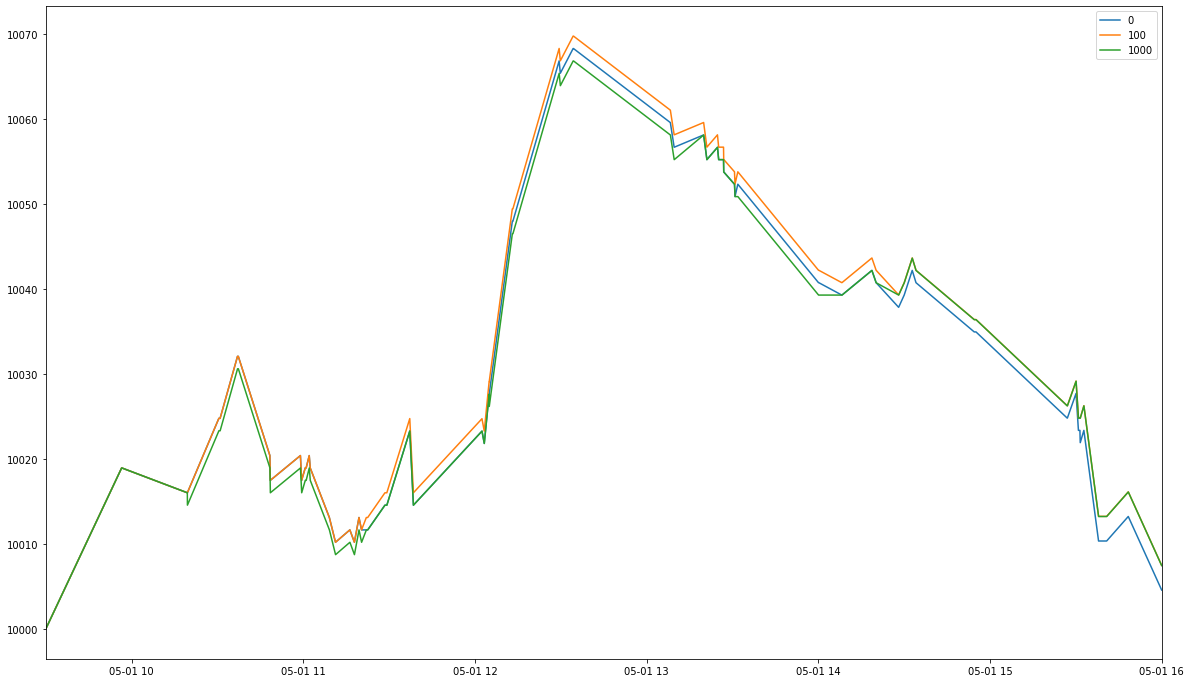

In [309]:
plt.figure(figsize=(20,12))
for delay in [0, 100, 1000]:
    series_balance = tradebook["OUTSTANDING_BALANCE_" + str(delay)]
    series_inventory = tradebook["OUTSTANDING_INVENTORY_" + str(delay)]
    series_balance = series_balance[series_inventory==0]
    series_balance.sort_index(ascending=True, inplace=True)
    print(series_balance)
    plt.plot(series_balance.index, series_balance.values, label=delay)

plt.legend()
plt.xlim(tradebook.index[0], tradebook.index[-1])    
plt.show()
    